In [3]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn import metrics


class NonExistingChoice(Exception):
    pass


def split_array(arr, q):
    # Рассчитываем индекс, по которому разделить массив
    split_index = int(len(arr) * q / 100)

    # Разделяем массив на две части
    arr_part1 = arr[:split_index]
    arr_part2 = arr[split_index:]

    return arr_part1, arr_part2

Функция генерации шума

In [4]:
def generate_noise(eps0):
    return np.random.uniform(-eps0, eps0)

Генерация Гауссовской выборки

In [5]:
def generate_gaussian(number_of_samples, mu, sigma, error_scale):
    x_train = np.zeros((number_of_samples, 2), dtype=float)
    y_train = np.zeros(number_of_samples, dtype=int)

    for i in range(number_of_samples):

        for j in range(2):
            x_train[i][j] = np.random.normal(loc=mu[j], scale=sigma[j], size=None)

        y_train[i] = 1 if (sum(x_train[i]) > 0) else 0

        for j in range(2):
            x_train[i] += generate_noise(error_scale)

    return x_train, y_train


def gaussian(number_of_samples, mu, sigma, error_scale):
    x_train_p, y_train_p = generate_gaussian(int(number_of_samples / 2), mu, sigma, error_scale)
    x_train_n, y_train_n = generate_gaussian(int(number_of_samples / 2), -1 * mu, sigma, error_scale)
    return np.concatenate((x_train_p, x_train_n)), np.concatenate((y_train_p, y_train_n))

Генерация круговой выборки

In [6]:
def circle(number_of_samples, radius, eps0):
    x_train = np.zeros((number_of_samples, 2), dtype=float)
    y_train = np.zeros(number_of_samples, dtype=int)

    n = int(number_of_samples / 2)

    for i in range(n):
        r = np.random.uniform(0, radius * 0.5)
        angle = np.random.uniform(0, 2 * np.pi)
        x_train[i] = [r * np.sin(angle) + generate_noise(eps0), r * np.cos(angle) + generate_noise(eps0)]
        y_train[i] = 0

    for i in range(n):
        R = np.random.uniform(radius * 0.7, radius)
        angle = np.random.uniform(0, 2 * np.pi)
        x_train[n + i] = [R * np.sin(angle) + generate_noise(eps0), R * np.cos(angle) + generate_noise(eps0)]
        y_train[i] = 1

    return x_train, y_train

Генерация выборки XOR

In [7]:
def xor_data(number_of_samples, start, stop, eps0):
    x_train = np.zeros((number_of_samples, 2), dtype=float)
    y_train = np.zeros(number_of_samples, dtype=int)
    for i in range(number_of_samples):
        x_train[i] = [np.random.uniform(start, stop), np.random.uniform(start, stop)]

        y_train[i] = 1 if (np.prod(np.array(x_train[i])) >= 0) else 0

        for j in range(2): x_train[i][j] += generate_noise(eps0)
    return x_train, y_train

Генерация спиральной выборки

In [8]:
def generate_spiral(number_of_samples, deltaT, label, eps0):
    x_train = np.zeros((number_of_samples, 2), dtype=float)
    y_train = np.zeros(number_of_samples, dtype=int)
    for i in range(number_of_samples):
        r = i / number_of_samples * 5
        t = 1.75 * i / number_of_samples * 2 * np.pi + deltaT
        x_train[i] = [r * np.sin(t) + generate_noise(eps0), r * np.cos(t) + generate_noise(eps0)]
        y_train[i] = label
    return x_train, y_train


def spiral_data(number_of_samples, eps0):
    x_train_p, y_train_p = generate_spiral(int(number_of_samples / 2), 0, 0, eps0)
    x_train_n, y_train_n = generate_spiral(int(number_of_samples / 2), np.pi, 1, eps0)
    return np.concatenate((x_train_p, x_train_n)), np.concatenate((y_train_p, y_train_n))

Импортируем torch

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

Класс многослойного персептрона

In [10]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        super(MultiLayerPerceptron, self).__init__()
        self.hidden_layers = nn.ModuleList([])
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        # Выбор функции активации
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.ReLU()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x
    

Обучение модели

In [11]:
def learning(model, x_train, y_train, num_epochs):
    criterion = nn.MSELoss() # Квадратичная функция потерь (MSE)
    optimizer = optim.SGD(model.parameters(), lr=0.01) # Стохастический градиентный спуск
    for epoch in range(num_epochs):
        # Прямой проход
        outputs = model(x_train).squeeze()
        loss = criterion(outputs, y_train)
    
        # Обратный проход и оптимизация
        optimizer.zero_grad() # Обнуление градиентов
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Оптимизация параметров

Получить точность

In [ ]:
def get_accuracy(targets_tensor, test_pred_tensor):
    binary_pred = torch.round(test_pred_tensor)
    correct_pred = torch.sum(torch.eq(targets_tensor, binary_pred))
    total_elements = targets_tensor.numel()
    return correct_pred / total_elements

Параметры модели многослойного персептрона

In [12]:
# Задание параметров модели
input_size = 2 # Размер входных данных (x_1, x_2)
hidden_sizes = [1, 1, 1] # Количество нейронов в каждом скрытом слое
output_size = 1 # Размер выходного класса y
activation = 'relu'  # Выбор функции активации: 'sigmoid', 'tanh' или 'relu'

num_epochs = 10000
number_of_samples = 500
eps0 = 0.05

# For Gaussian
mu = np.array([1.0, 1.0])
sigma = np.array([1, 1])

# For Circle
radius = 10

# Ratio of training to test data
ratio = 50

start = -5
stop = 5
step = 0.1

Создание модели, выборок и обучение

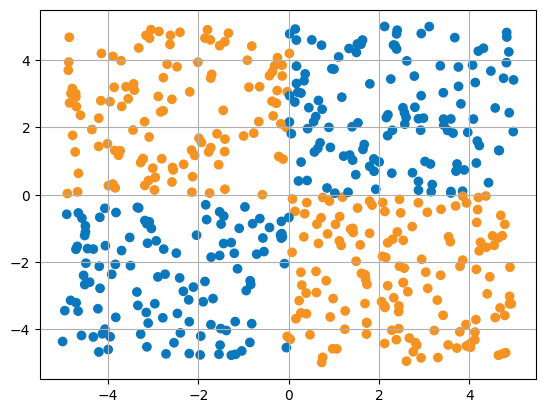

In [22]:
# Создание экземпляра модели
model = MultiLayerPerceptron(input_size, hidden_sizes, output_size, activation)
sample_type = input()
if sample_type == "g":
    features, targets = gaussian(number_of_samples, mu, sigma, eps0)
elif sample_type == "c":
    features, targets = circle(number_of_samples, radius, eps0)
elif sample_type == "x":
    features, targets = xor_data(number_of_samples, start, stop, eps0)
elif sample_type == "s":
    features, targets = spiral_data(number_of_samples, eps0)
else:
    raise NonExistingChoice

combined = list(zip(features, targets))
random.shuffle(combined)
trains, tests = split_array(combined, ratio)

x_train, y_train = zip(*trains)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test, y_test = zip(*tests)

x1 = [point[0] for point in features]
x2 = [point[1] for point in features]
colors = ["#f59322" if point == 0 else "#0B77bd" for point in targets]
plt.scatter(x1, x2, c=colors)

plt.grid(True)
plt.show()

start_time = time.time()
learning(model, x_train_tensor, y_train_tensor, num_epochs)
end_time = time.time()

Работа на тестовой выборке

Predicted outputs: tensor([[0.6297],
        [0.6297],
        [0.3071],
        [0.6297],
        [0.4449],
        [0.6297],
        [0.6297],
        [0.4453],
        [0.6297],
        [0.6297],
        [0.4169],
        [0.5307],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.5180],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.1408],
        [0.6297],
        [0.6297],
        [0.6090],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.0000],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.1381],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.0277],
        [0.6297],
        [0.6297],
        [0.4641],
        [0.6297],
        [0.6297],
        [0.6297],
        [0.4375],
        [0.6297],
        [

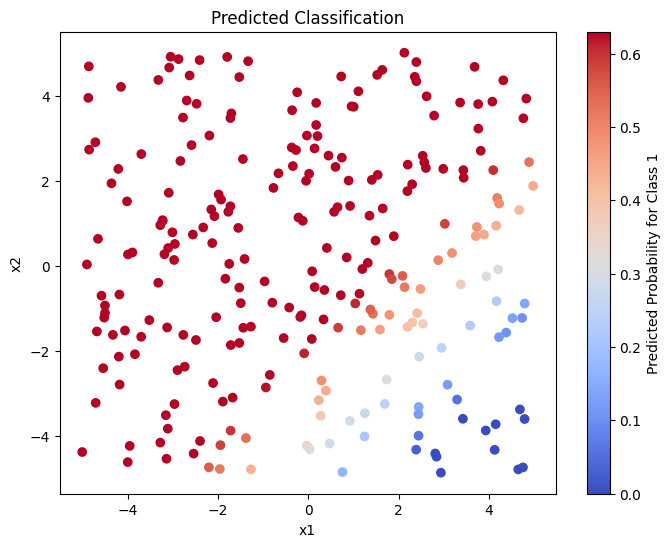

In [26]:
X_test = torch.tensor(x_test, dtype=torch.float32) # Новые входные данные (x_1, x_2)
predicted = torch.relu(model(X_test)) # Предсказанные значения с применением сигмоидальной функции активации
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
error = torch.nn.BCELoss(predicted, y_test)
print("Predicted outputs:", predicted)
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted.detach().numpy().reshape(-1), cmap='coolwarm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Predicted Classification')
plt.colorbar(label='Predicted Probability for Class 1')
plt.show()